# Distributions of training and test data

Get a feeling for the different distributions, regarding their

* seasonality
* sea ice concentration
* place

(this should reproduce fig. 4 from `AI4SeaIce: Toward Solving Ambiguous SAR Textures in Convolutional Neural Networks for Automatic Sea Ice Concentration Charting`)

Caveat: the size of the different scence can be an order of magnitude different, so we need to weight the different scenes by their size.
This is approximately correct, however I think there was sth about some parts of the scenes being more interesting and if it's only open sea it does not count anymore.

Caveat 2: we do not know much abou the distribution of the data on which our models will be scored. We only have the corresponding charts.

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import xarray as xr
import gc

In [2]:
# format: S1X_EW_GRDM_1SDH_YYYYMMDDThhmmss_YYYYMMDDThhmmss_xxxxxx_xxxxxx_xxXX_icechart_icechartname_depending_on_provider.nc
# S1X = Sentinel 1A or 1B
# EW = East-West (?)
# GRDM = Ground Range Detected Mode (?)
# 1SDH = Single Look Complex (?)
# YYYYMMDDThhmmss = Start of acquisition
# YYYYMMDDThhmmss = End of acquisition
# xxxxxx = Orbit number (?)
# xxxxxx = Relative orbit number (?)
# xxXX = Polarisation (?)
# icechart = icechart
# icechartname
#   cis_<location>_<date>_pl_a.nc
#   dmi_<date>_<location>_RIC.nc
test_string_cis = "S1A_EW_GRDM_1SDH_20190430T101830_20190430T101930_027018_030AD3_9C47_icechart_cis_SGRDIEA_20190430T1020Z_pl_a.nc"
test_string_dmi = "S1B_EW_GRDM_1SDH_20191212T210345_20191212T210445_019337_024852_C7CA_icechart_dmi_201912122105_NorthWest_RIC.nc"

print(test_string_cis.split("_"))
print(test_string_dmi.split("_"))

['S1A', 'EW', 'GRDM', '1SDH', '20190430T101830', '20190430T101930', '027018', '030AD3', '9C47', 'icechart', 'cis', 'SGRDIEA', '20190430T1020Z', 'pl', 'a.nc']
['S1B', 'EW', 'GRDM', '1SDH', '20191212T210345', '20191212T210445', '019337', '024852', 'C7CA', 'icechart', 'dmi', '201912122105', 'NorthWest', 'RIC.nc']


In [3]:
# load the json files in the datalists folder
with open('datalists/dataset.json', 'r') as f:
    dataset = json.load(f)
with open('datalists/testset.json', 'r') as f:
    testset = json.load(f)

# create a dataframe from the json files
dataset_df = pd.DataFrame(dataset)
testset_df = pd.DataFrame(testset)

# create a dataframe with both dataset_df and testset_df with a new column indicating the dataset
dataset_df['dataset'] = 'dataset'
testset_df['dataset'] = 'testset'
df = pd.concat([dataset_df, testset_df], ignore_index=True)

# get the duplicates -> no duplicates
df[df.duplicated(subset=[0], keep='last') == True]

# split the value of the column '0' on each '_' and create a new column for each value
df["Sentinel_mission_identifier"] = df[0].str.split("_").str[0]
df["misc"] = df[0].str.split("_").str[1:4]
df["image_acquisition_start_date"] = df[0].str.split("_").str[4]
df["image_acquisition_start_date"] = pd.to_datetime(df["image_acquisition_start_date"], format='%Y%m%dT%H%M%S')
df["image_acquisition_end_date"] = df[0].str.split("_").str[5]
df["image_acquisition_end_date"] = pd.to_datetime(df["image_acquisition_end_date"], format='%Y%m%dT%H%M%S')
df["image_type"] = df[0].str.split("_").str[9]
df["icechart_provider"] = df[0].str.split("_").str[10]
df["location"]  = np.nan
df["icechart_date"] = np.nan

for i in range(0, len(df)):
    if df["icechart_provider"][i] == 'cis':
        df.loc[(i, "location")] = df[0][i].split("_")[11]
        try:
            df.loc[(i, "icechart_date")] = df[0][i].split("_")[12]
            df.loc[(i, "icechart_date")] = pd.to_datetime(df["icechart_date"][i], format='%Y%m%dT%H%MZ')
        except ValueError:
            df.loc[(i, "icechart_date")] = np.nan
    elif df["icechart_provider"][i] == 'dmi':
        try:
            df.loc[(i, "icechart_date")] = df[0][i].split("_")[11]
            df.loc[(i, "icechart_date")] = pd.to_datetime(df["icechart_date"][i], format='%Y%m%d%H%M%S')
        except ValueError:
            df.loc[(i, "icechart_date")] = np.nan
        df.loc[(i, "location")] = df[0][i].split("_")[12]

In [4]:
# add columns called hour, month, year based on the image_acquisition_start_date

df["month"] = df["image_acquisition_start_date"].dt.month.astype(int)
df["hour"] = df["image_acquisition_start_date"].dt.hour.astype(int)
df["year"] = df["image_acquisition_start_date"].dt.year.astype(int)

In [5]:
# get the size of the scenes and add it to the dataframe

df["size"] = np.nan

# the prepared scenes are uniquely identified by <test_data>/<image_acquisition_start_date>_<icechart_provider>_prep.nc

path_to_scenes = os.environ['AI4ARCTIC_DATA']

for i in range(0, len(df)):
    if df["dataset"][i] == 'dataset':
        try:
            path = os.path.join(path_to_scenes, df["image_acquisition_start_date"][i].strftime('%Y%m%dT%H%M%S') + '_' + df["icechart_provider"][i] + '_prep.nc')
            df.loc[(i, "size")] = os.path.getsize(path)
        except:
            print(df.iloc[i])
    elif df["dataset"][i] == 'testset':
        try:
            path = os.path.join(path_to_scenes, 'test_data', df["image_acquisition_start_date"][i].strftime('%Y%m%dT%H%M%S') + '_' + df["icechart_provider"][i] + '_prep.nc')
            df.loc[(i, "size")] = os.path.getsize(path)
        except FileNotFoundError:
            print(df.loc[i])
        

In [6]:
df.head()

,0,dataset,Sentinel_mission_identifier,misc,image_acquisition_start_date,image_acquisition_end_date,image_type,icechart_provider,location,icechart_date,month,hour,year,size
0,S1A_EW_GRDM_1SDH_20190430T101830_20190430T1019...,dataset,S1A,"[EW, GRDM, 1SDH]",2019-04-30 10:18:30,2019-04-30 10:19:30,icechart,cis,SGRDIEA,2019-04-30 10:20:00,4,10,2019,136108073.0
1,S1A_EW_GRDM_1SDH_20200626T104258_20200626T1043...,dataset,S1A,"[EW, GRDM, 1SDH]",2020-06-26 10:42:58,2020-06-26 10:43:58,icechart,cis,SGRDIEA,2020-06-26 10:33:00,6,10,2020,136862155.0
2,S1A_EW_GRDM_1SDH_20180728T101728_20180728T1018...,dataset,S1A,"[EW, GRDM, 1SDH]",2018-07-28 10:17:28,2018-07-28 10:18:28,icechart,cis,SGRDIEA,2018-07-28 10:18:00,7,10,2018,138966375.0
3,S1A_EW_GRDM_1SDH_20200110T104255_20200110T1043...,dataset,S1A,"[EW, GRDM, 1SDH]",2020-01-10 10:42:55,2020-01-10 10:43:55,icechart,cis,SGRDIEA,2020-01-10 10:33:00,1,10,2020,100129851.0
4,S1A_EW_GRDM_1SDH_20190809T214629_20190809T2147...,dataset,S1A,"[EW, GRDM, 1SDH]",2019-08-09 21:46:29,2019-08-09 21:47:05,icechart,cis,SGRDIEA,2019-08-09 21:59:00,8,21,2019,56423304.0


/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


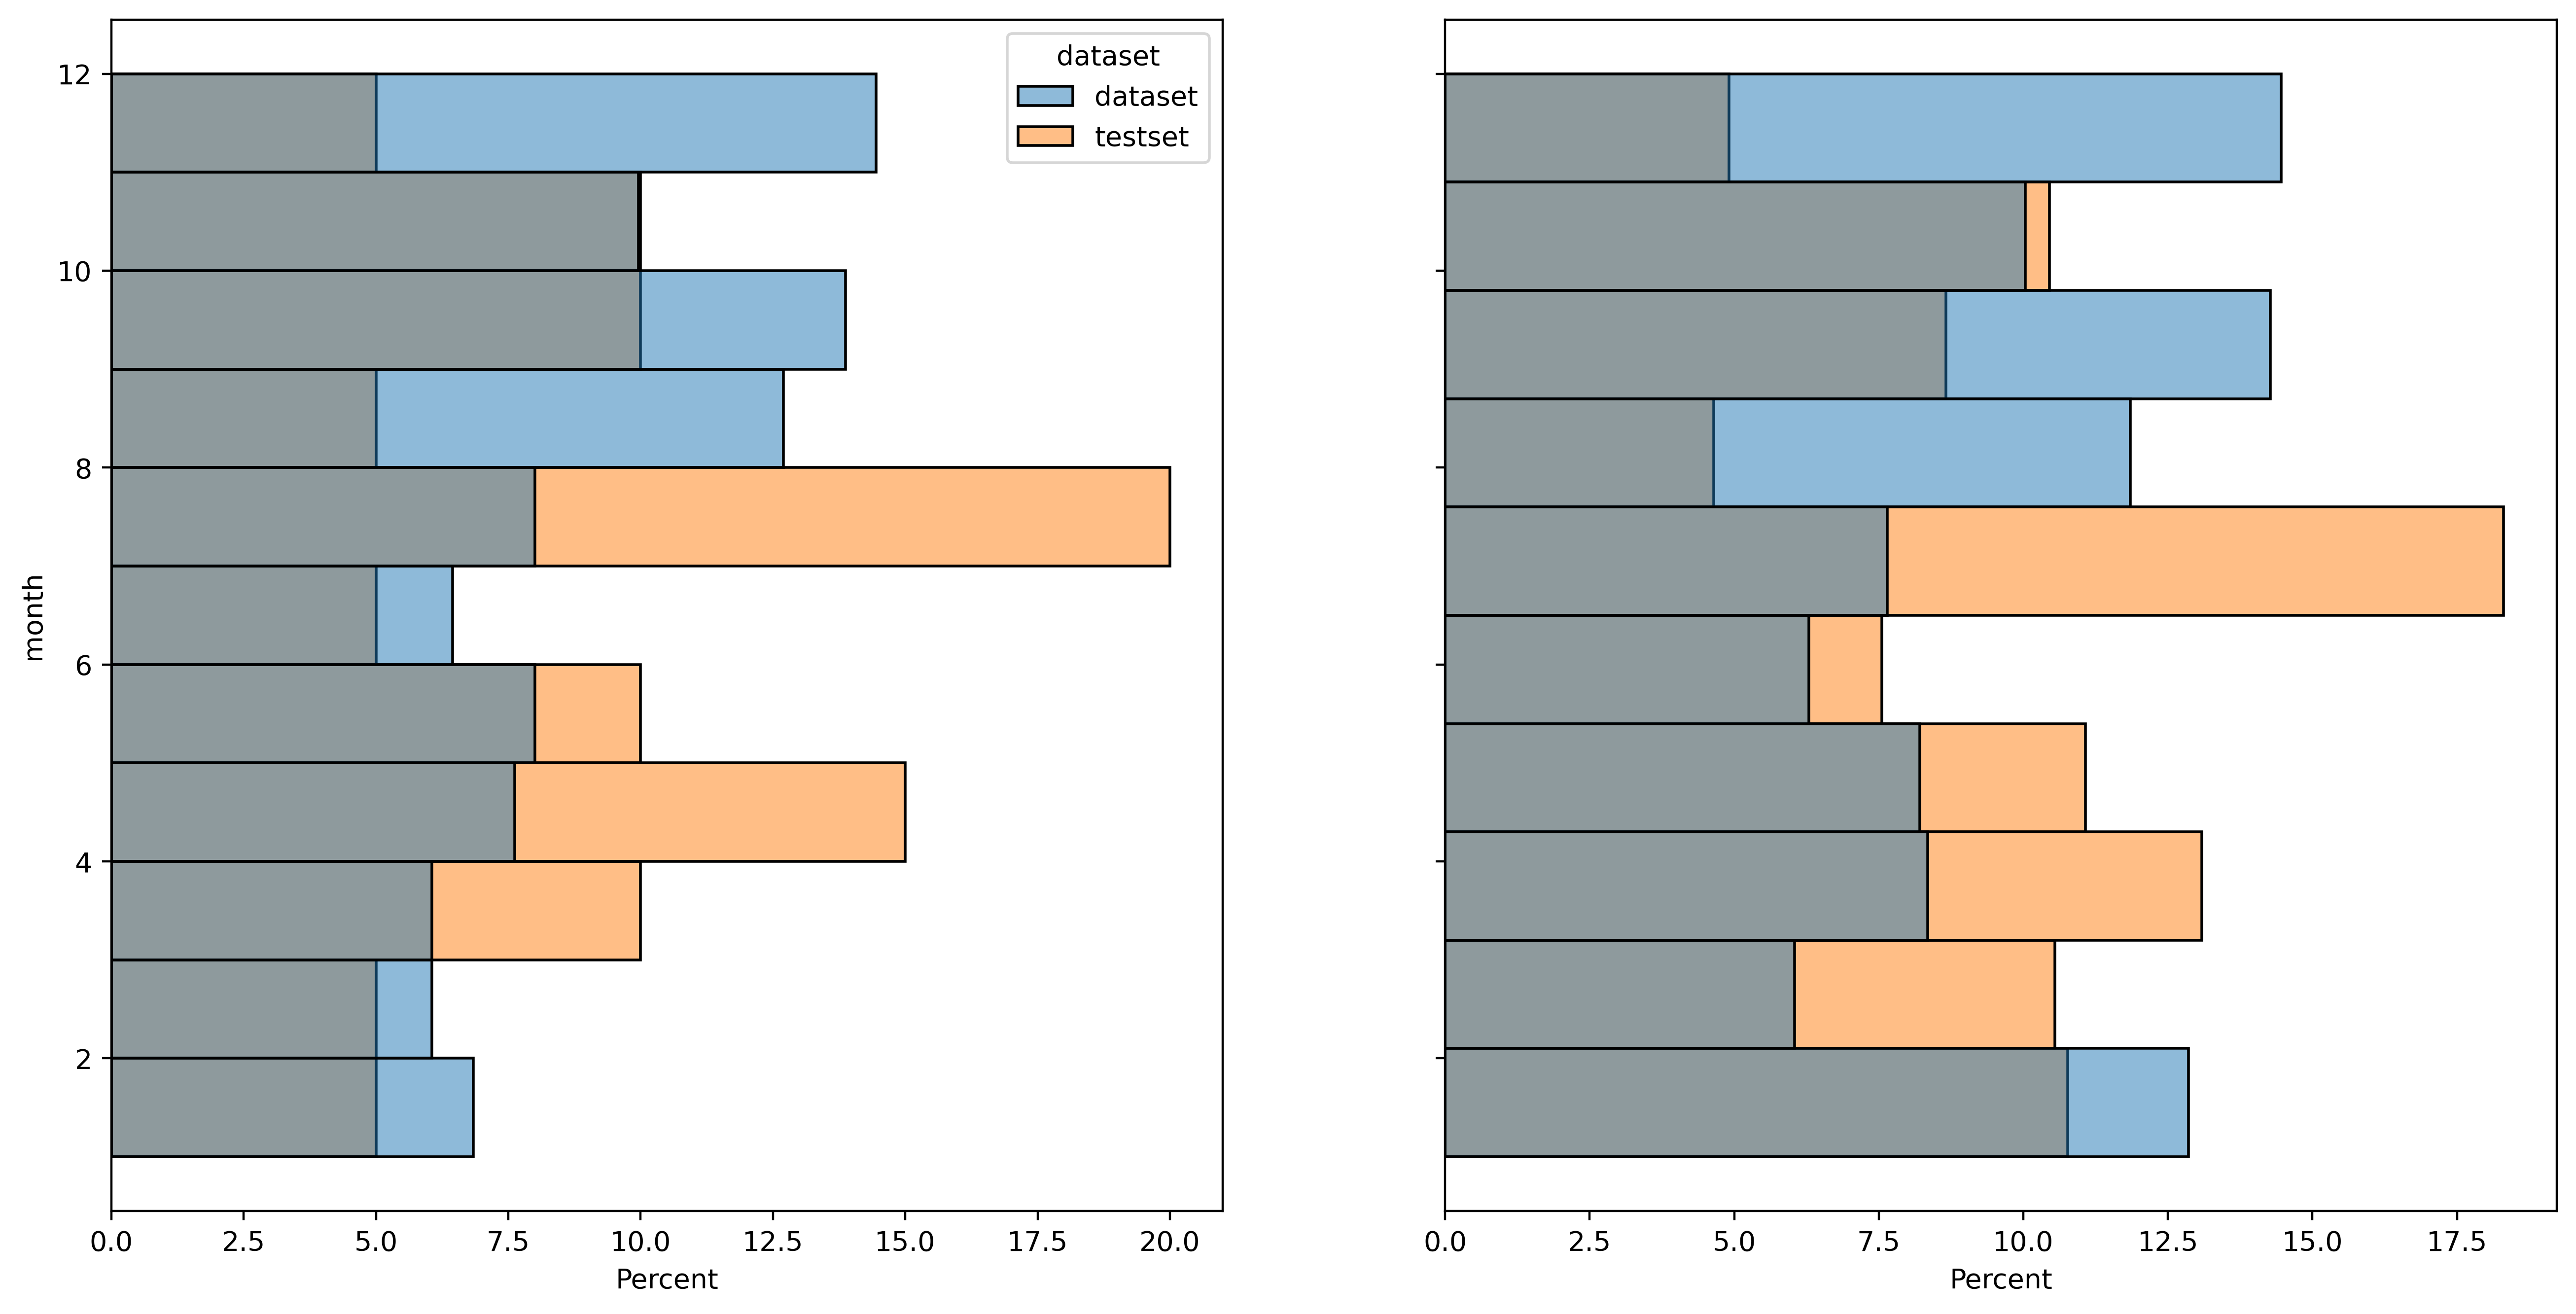

/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


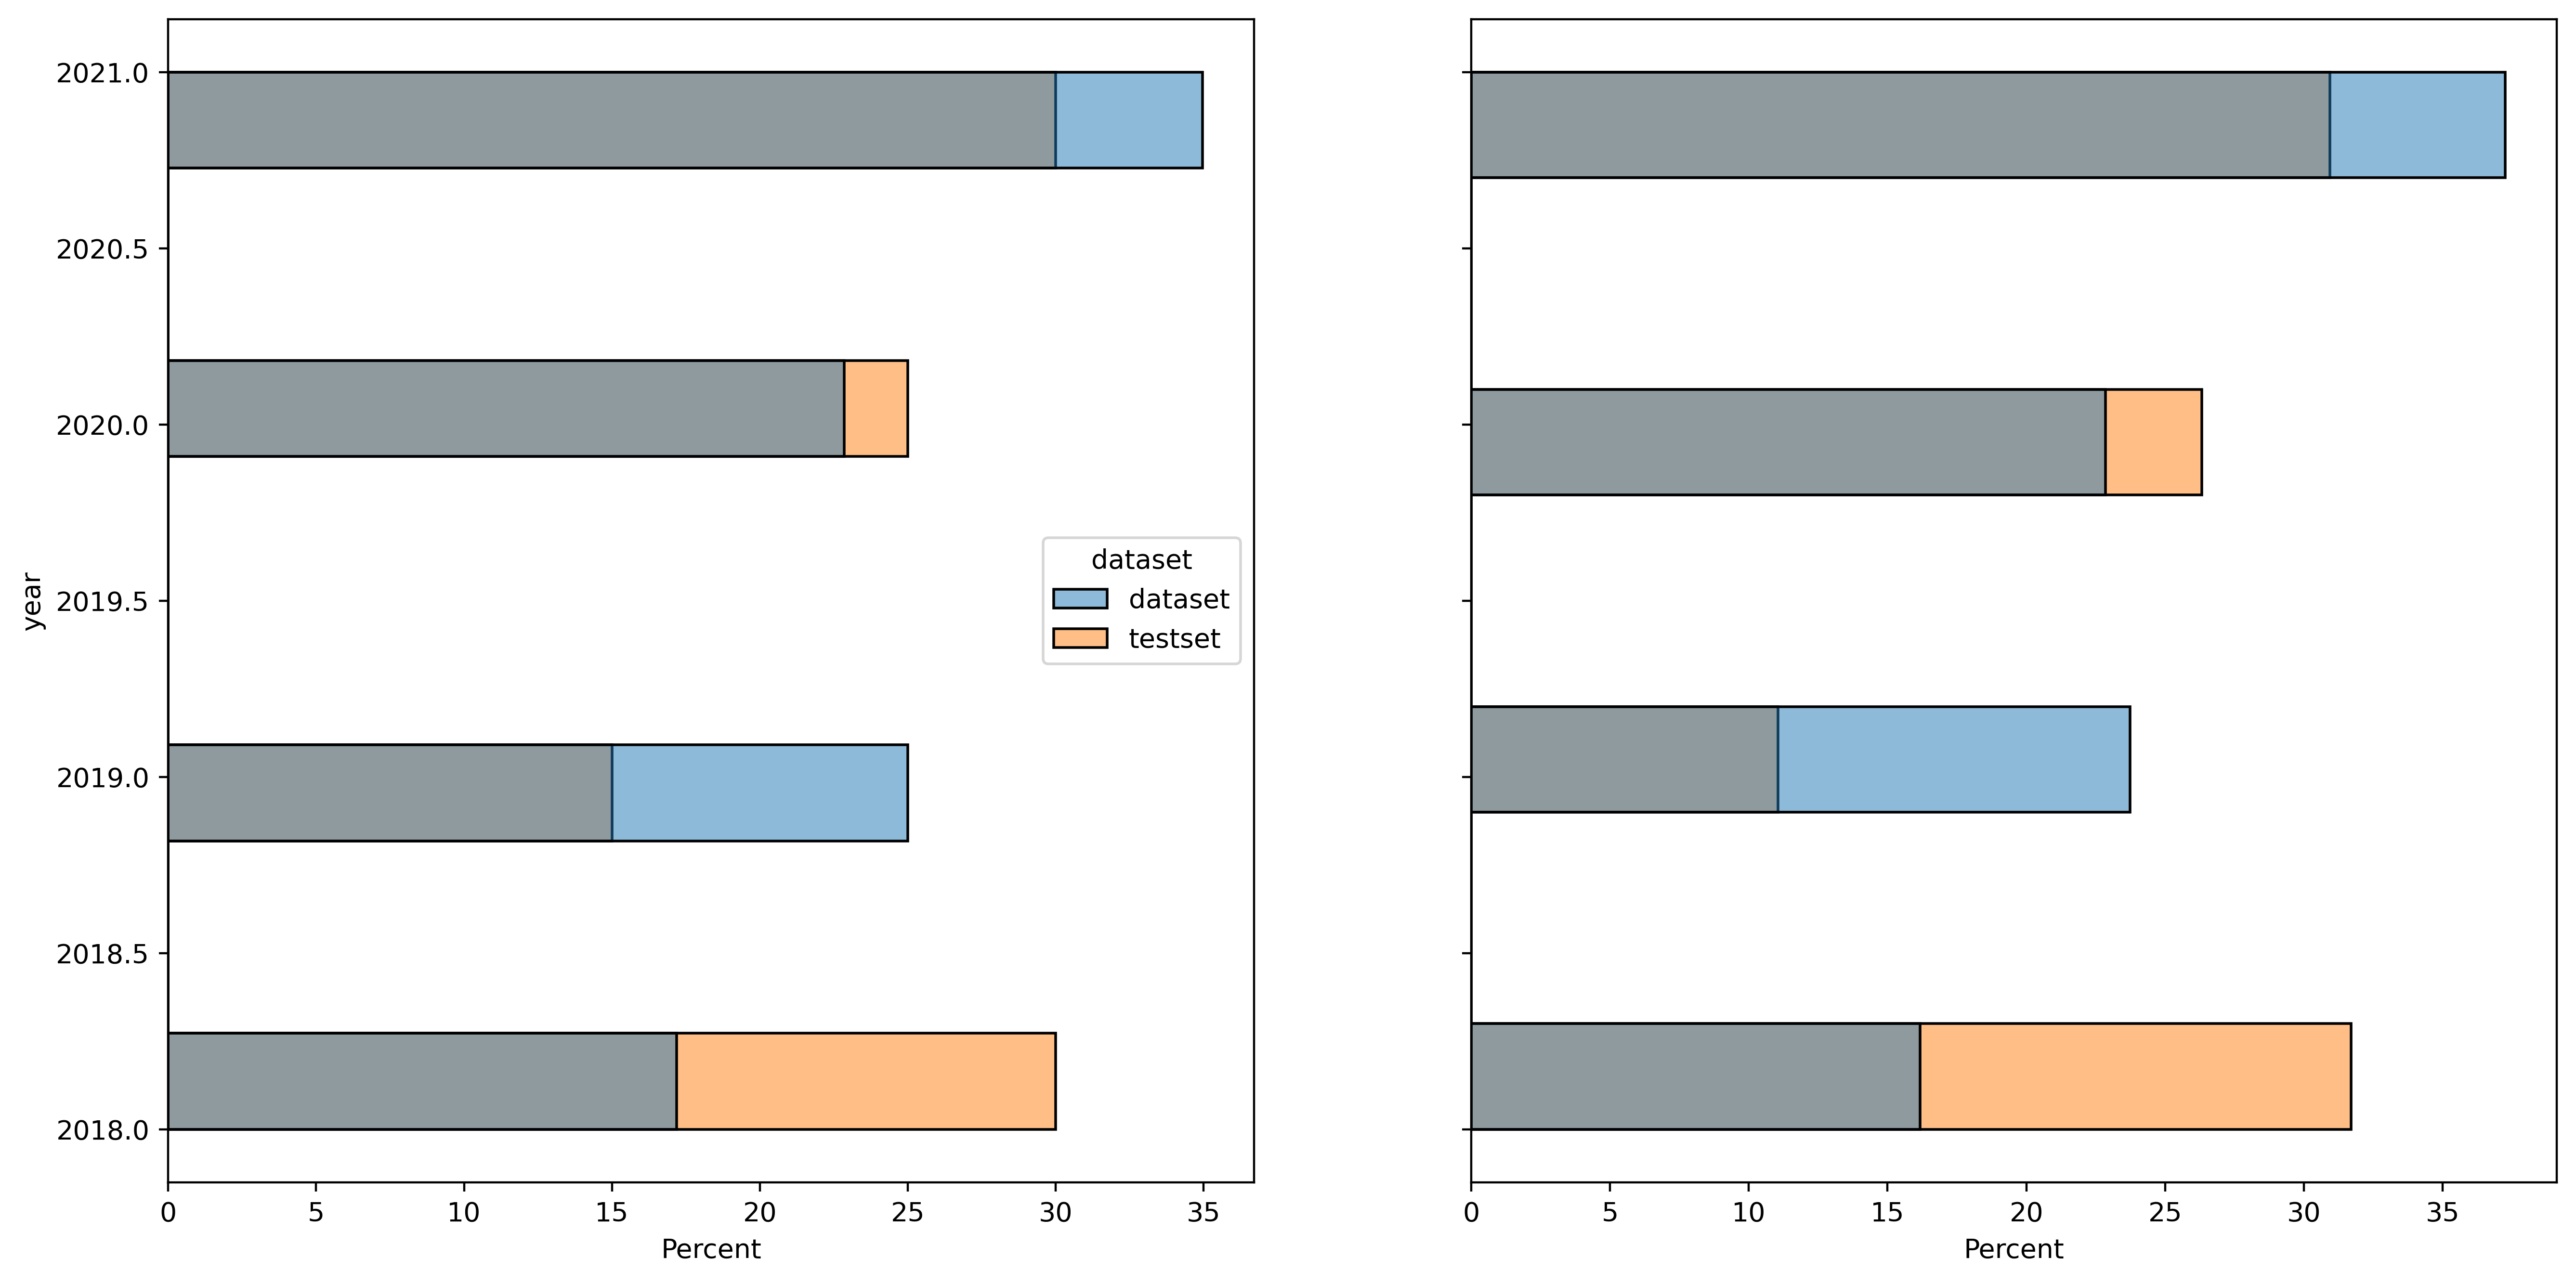

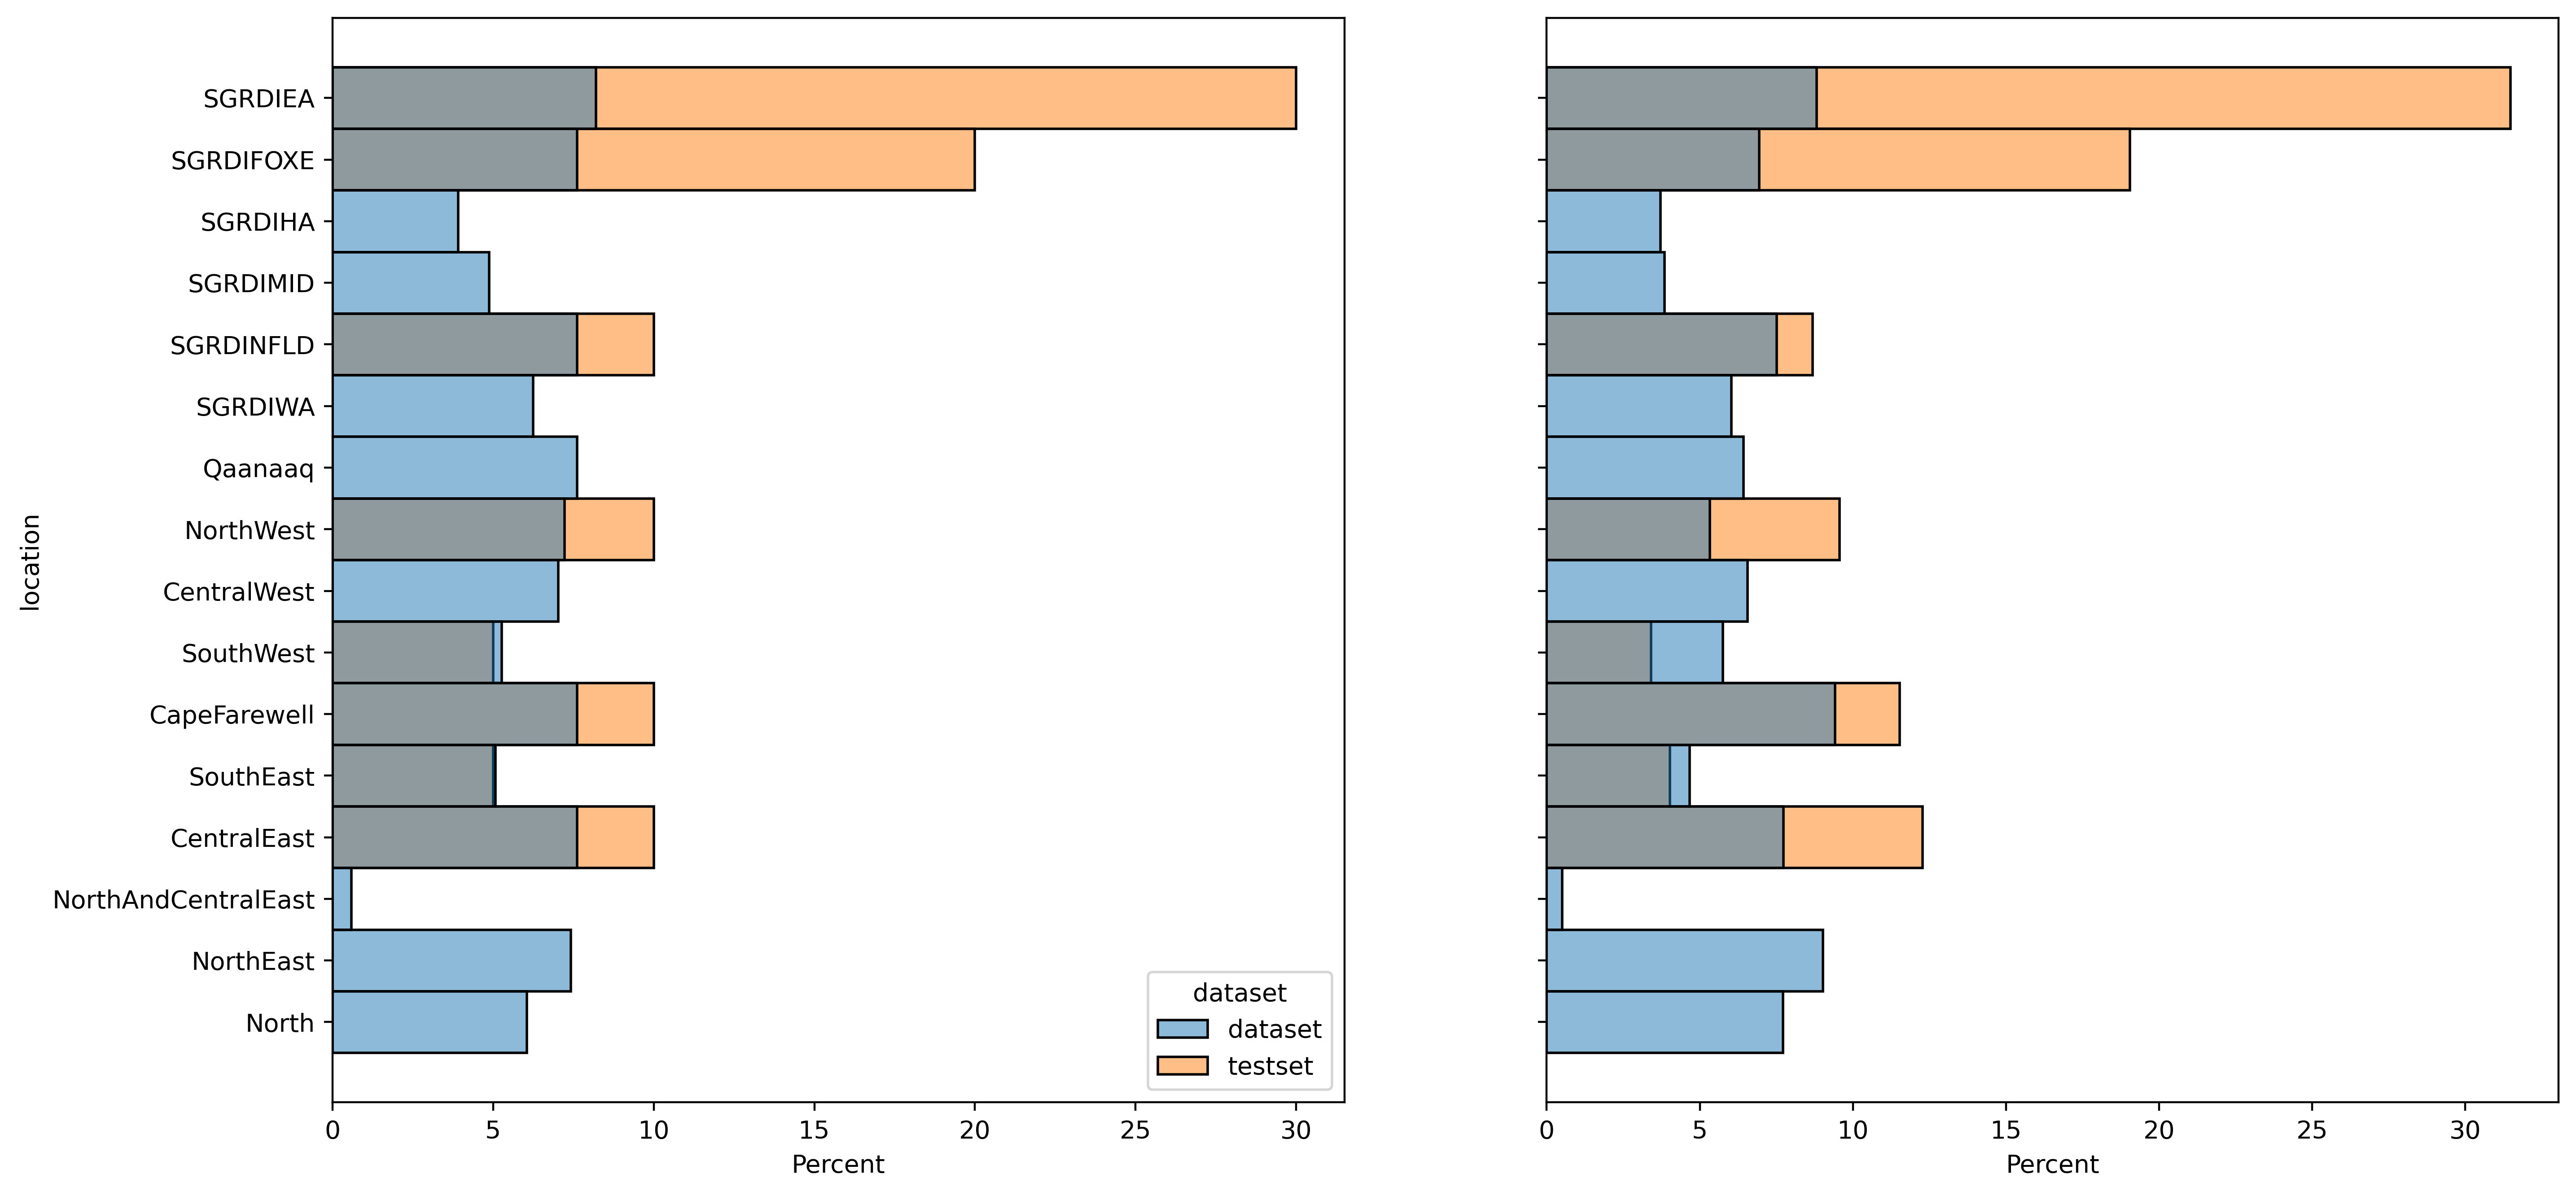

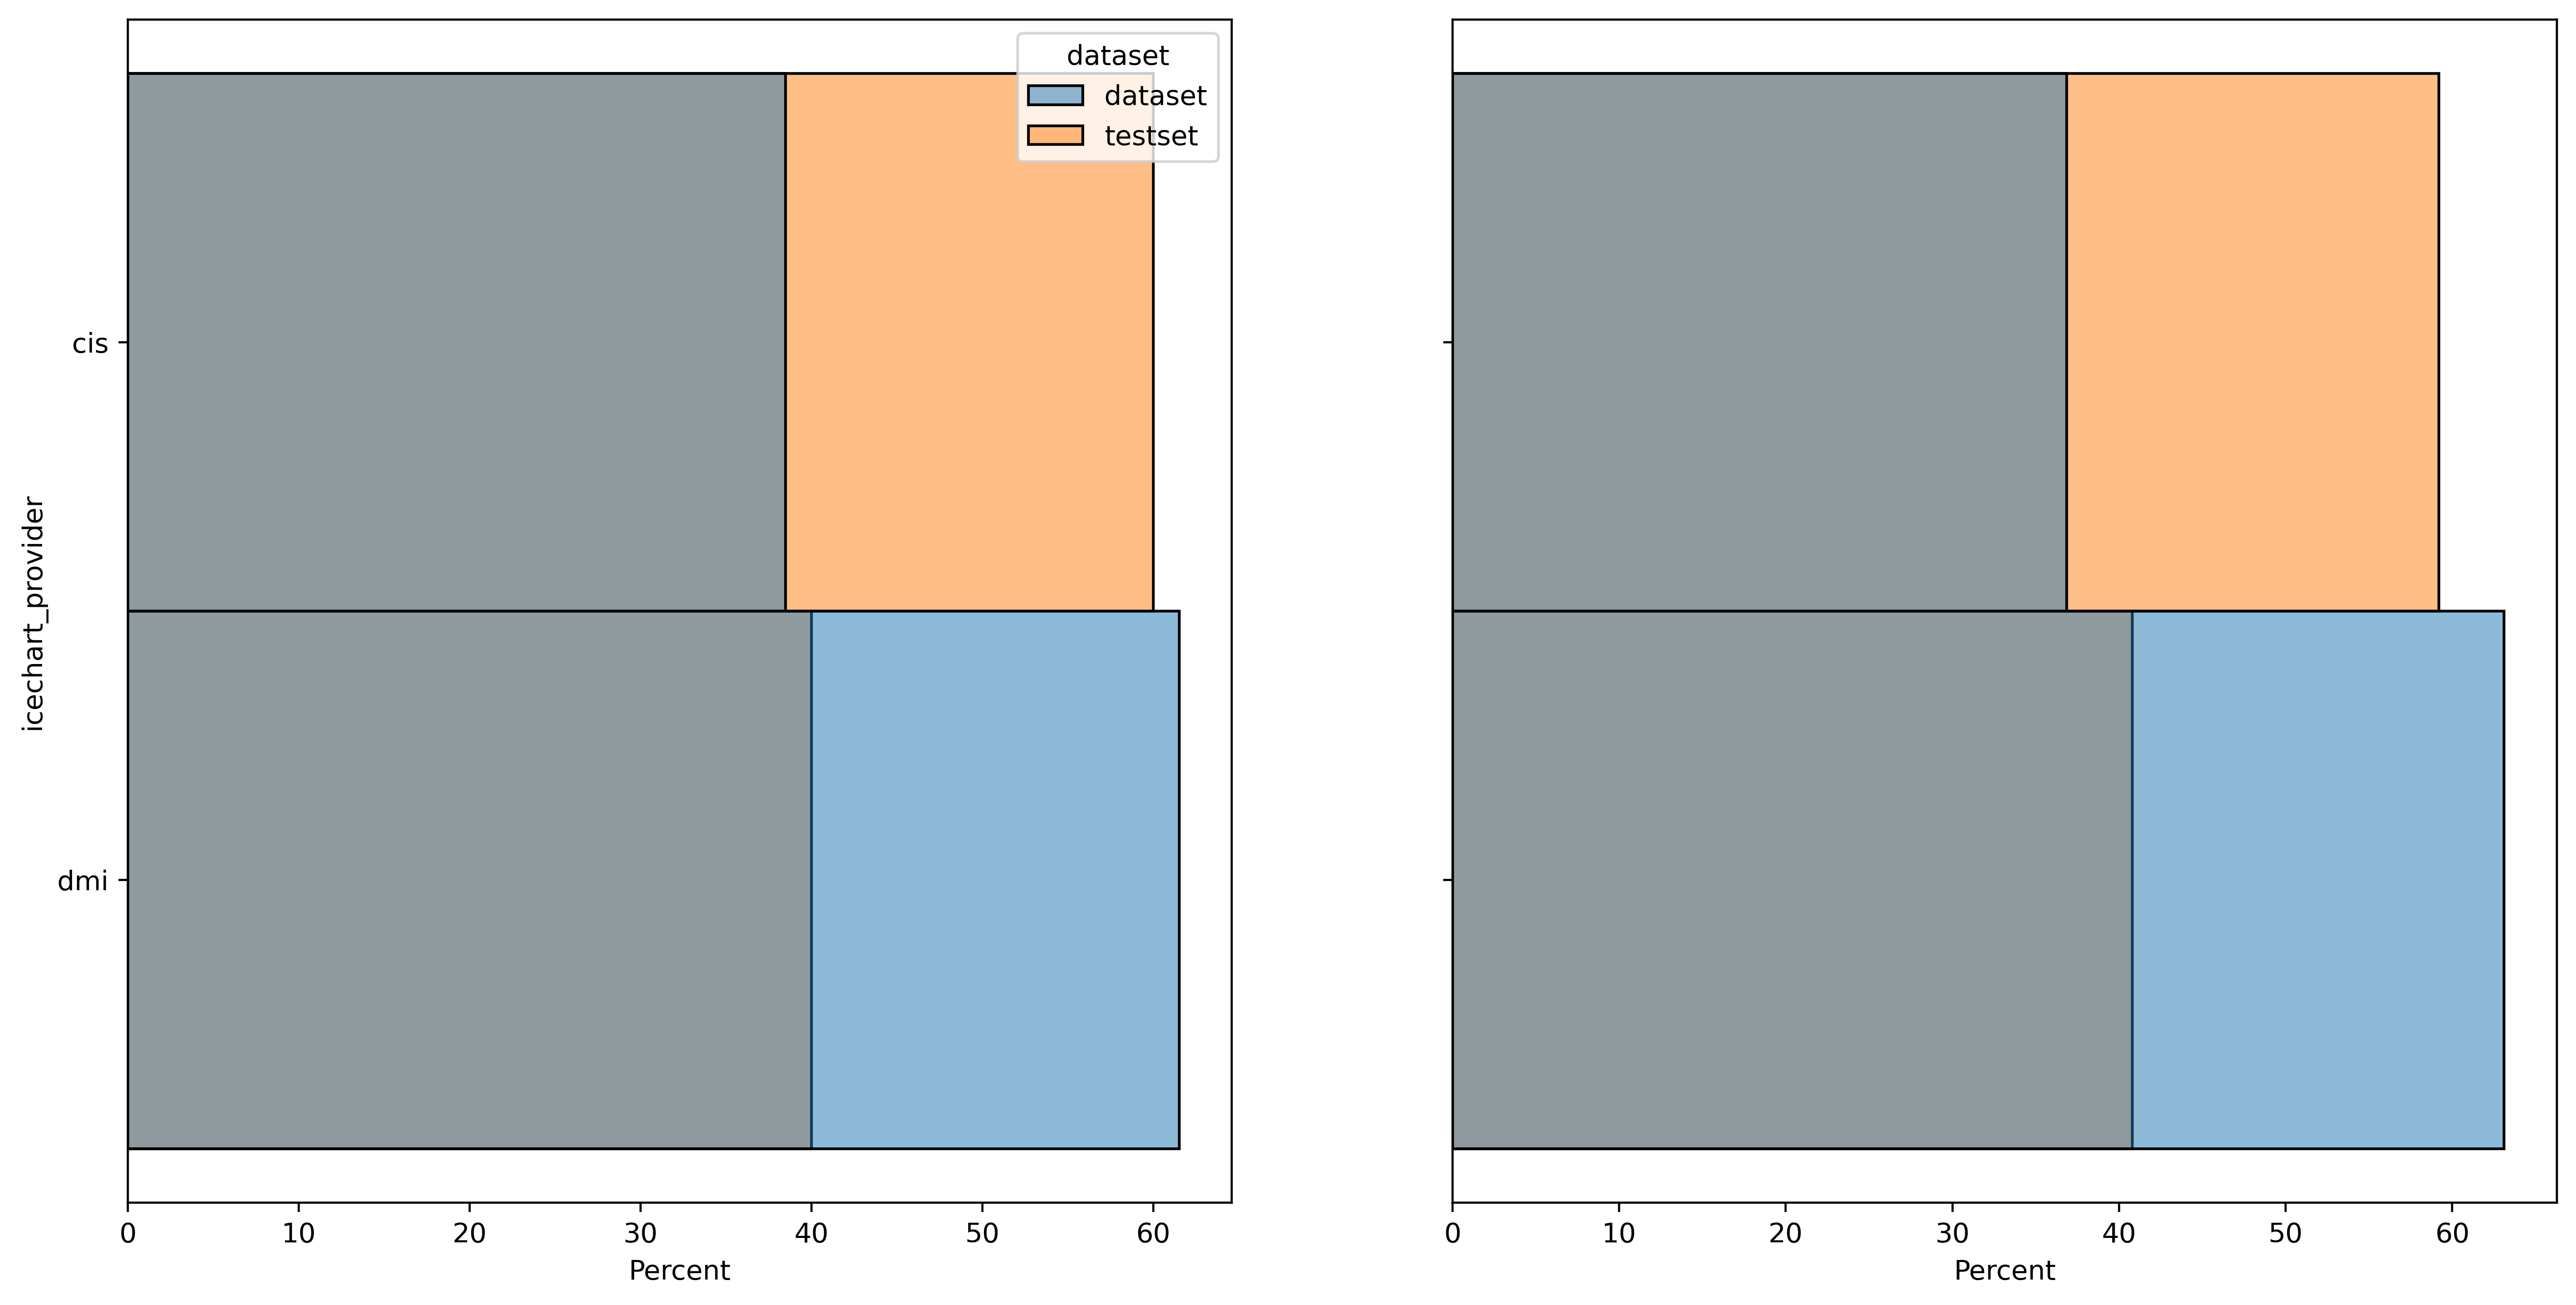

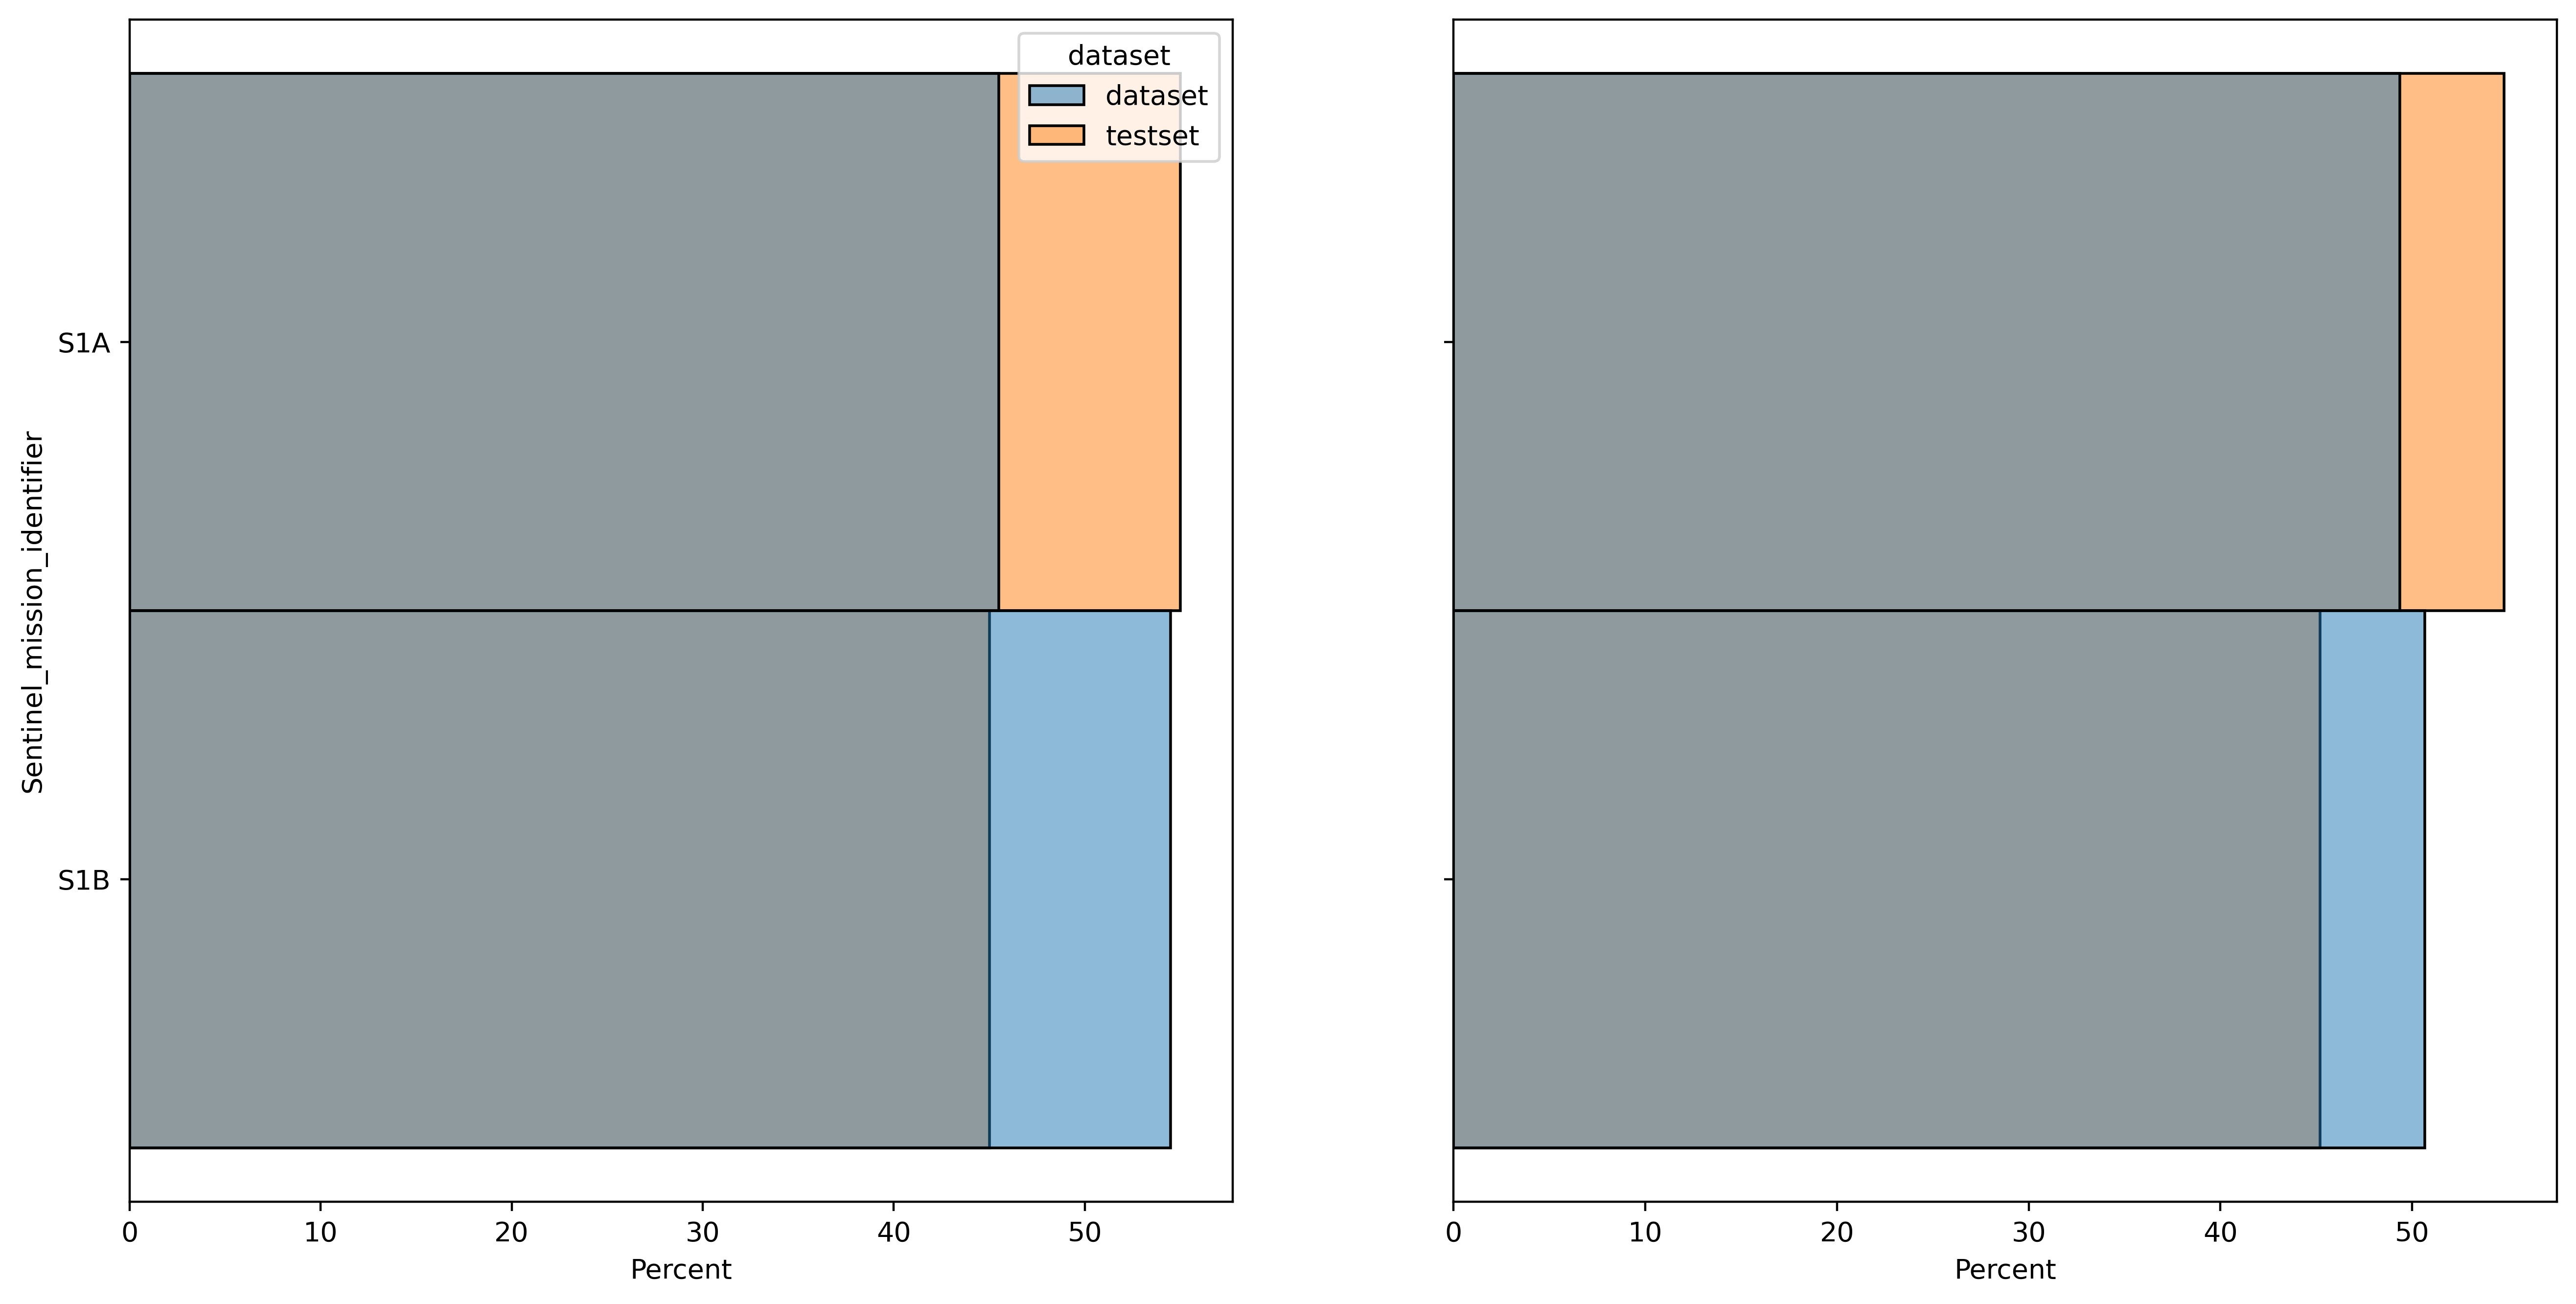

In [7]:
# plot the distribution of the months, grouped by dataset versus testset
# norm on the size column
# show one plot not weighted on the size and one weighted on the size of the scenes

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16,8), dpi=400)
sns.histplot(y="month", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[0])
sns.histplot(y="month", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[1], weights='size', legend=False)
plt.show()

# plot the distribution of the years, grouped by dataset versus testset

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16,8), dpi=400)
sns.histplot(y="year", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[0])
sns.histplot(y="year", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[1], weights='size', legend=False)
plt.show()

# plot the distribution of the location, grouped by dataset versus testset

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16,8), dpi=400)
sns.histplot(y="location", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[0])
sns.histplot(y="location", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[1], weights='size', legend=False)
plt.show()

# plot the distribution of the icechart_provider, grouped by dataset versus testset

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16,8), dpi=400)
sns.histplot(y="icechart_provider", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[0])
sns.histplot(y="icechart_provider", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[1], weights='size', legend=False)
plt.show()

# plot the distribution of the Sentinel_mission_identifier, grouped by dataset versus testset

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16,8), dpi=400)
sns.histplot(y="Sentinel_mission_identifier", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[0])
sns.histplot(y="Sentinel_mission_identifier", hue="dataset", data=df, stat='percent', common_norm=False, ax=axs[1], weights='size', legend=False)
plt.show()


In [8]:
# kdeplot plot of the hour versus the month, grouped by dataset versus testset

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(48,12), dpi=400)
sns.kdeplot(x="hour", y="month", hue="dataset", data=df,
            fill=True, common_norm=False, alpha=.5, 
            linewidth=0, cut=0,
            ax=axs[0])
sns.kdeplot(x="hour", y="month", hue="dataset", data=df,
            fill=True, common_norm=False, alpha=.5, 
            linewidth=0, cut=0,
            ax=axs[1], weights='size', legend=False)
plt.show()

/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


There could be interesting differences in the kinds of ice that are in training and in the test set:

In [9]:
from utils import CHARTS, SIC_GROUPS, SOD_GROUPS, FLOE_GROUPS
from utils import SOD_LOOKUP, SIC_LOOKUP, FLOE_LOOKUP

classes = {}
classes['SIC'] = list(SIC_GROUPS.keys()) + [SIC_LOOKUP['mask']]
classes['SOD'] = list(SOD_GROUPS.keys()) + [SOD_LOOKUP['mask']]
classes['FLOE'] = list(FLOE_GROUPS.keys()) + [FLOE_LOOKUP['mask']]

# create empty columns
for key, value in classes.items():
    for i in range(0, len(value)):
        df[f'{key}_{str(value[i])}'] = np.nan

In [10]:
for i in range(0, len(df)):
    gc.collect()
    
    if df["dataset"][i] == 'dataset':
        path = os.path.join(path_to_scenes, df["image_acquisition_start_date"][i].strftime('%Y%m%dT%H%M%S') + '_' + df["icechart_provider"][i] + '_prep.nc')
    elif df["dataset"][i] == 'testset':
        path = os.path.join(path_to_scenes, 'test_data', df["image_acquisition_start_date"][i].strftime('%Y%m%dT%H%M%S') + '_' + df["icechart_provider"][i] + '_prep.nc')

    scene = xr.open_dataset(path)

    for chart, value in classes.items():
        for j in range(0, len(value)):
            if df["dataset"][i] == 'dataset':
                df.loc[(i,f'{chart}_{str(value[j])}')] = np.count_nonzero(scene[chart] == value[j])
            elif df["dataset"][i] == 'testset':
                continue

    del scene

In [11]:
df[df['dataset'] == 'dataset']['size'].sum()

60201065698.0

In [12]:
total_n_samples_train = df[df['dataset'] == 'dataset'].shape[0]
ratio_icechart_provider_train = df[df['dataset'] == 'dataset']['icechart_provider'].value_counts() / total_n_samples_train
print(ratio_icechart_provider_train)

total_n_samples_test = df[df['dataset'] == 'testset'].shape[0]
ratio_icechart_provider_test = df[df['dataset'] == 'testset']['icechart_provider'].value_counts() / total_n_samples_test
print(ratio_icechart_provider_test)

weights = np.ones(df.shape[0])
df['icechart_weights'] = 1.
for i in range(0, df.shape[0]):
    if df['dataset'][i] == 'dataset':
        df.loc[(i, 'icechart_weights')] += (ratio_icechart_provider_test[df.iloc[i]['icechart_provider']] - ratio_icechart_provider_train[df.iloc[i]['icechart_provider']]) / ratio_icechart_provider_train[df.iloc[i]['icechart_provider']]

df['icechart_weights2'] = 1.
df['icechart_weights2'] = df['icechart_weights2'] + (ratio_icechart_provider_test[df['icechart_provider']] - ratio_icechart_provider_train[df['icechart_provider']]) / ratio_icechart_provider_train[df['icechart_provider']]

# check whether the sum of the weights is equal to the number of samples
print(f"The sum of the weights {df['icechart_weights'].sum()} should be equal to the number of samples {df.shape[0]}")

with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(df.iloc[200:250][['icechart_provider', 'icechart_weights']])

dmi    0.615234
cis    0.384766
Name: icechart_provider, dtype: float64
cis    0.6
dmi    0.4
Name: icechart_provider, dtype: float64


/tmp/ipykernel_159218/3683082765.py:16: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df['icechart_weights2'] = df['icechart_weights2'] + (ratio_icechart_provider_test[df['icechart_provider']] - ratio_icechart_provider_train[df['icechart_provider']]) / ratio_icechart_provider_train[df['icechart_provider']]


ValueError: cannot reindex on an axis with duplicate labels

In [41]:
ratio = df['month'].value_counts() / df.shape[0]
df['month_weight'] = 1 + (ratio[df['month']].values - 0.5) / 0.5

df['weight'] = 1.
df[['dataset', 'weight']]

df.loc[df['dataset'] != 'testset','weight'] = 0.
df[['dataset', 'weight']]

,dataset,weight
0,dataset,0.0
1,dataset,0.0
2,dataset,0.0
3,dataset,0.0
4,dataset,0.0
...,...,...
527,testset,1.0
528,testset,1.0
529,testset,1.0
530,testset,1.0


In [26]:
# get curent path
path = os.getcwd()

In [30]:
import glob


files = glob.glob(f"{path}/misc/distribution_*.csv")
files

['/home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/AI_in_industry/project/AI4ArcticSeaIceChallenge/misc/distribution_0.csv',
 '/home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/AI_in_industry/project/AI4ArcticSeaIceChallenge/misc/distribution_42.csv']

In [ ]:
import pandas as pd
df = pd.DataFrame({'A': [1, 1, 1,1,1], 'B': [False, True, False,True,False]})

weight = df['B'].value_counts()[True] / df['B'].value_counts()[False]

df['B'] = df['B'].map({False: -weight, True: 1})
df['B'] * df['A']

0   -0.666667
1    1.000000
2   -0.666667
3    1.000000
4   -0.666667
dtype: float64

In [23]:
import numpy as np
np.random.choice(a=df.index, size=1).item()

0

## Image coverage of the training

We train on $8*256^2$ pixel batches and do this $500$ times for $50$ epochs. This means we have $8*256^2*500*50=1.3e9$ pixel covered. Now compare this to the total number of pixels in the training data set.

Furthermore, as we only use 10 validation scenes, we validate only on approximately $2\%$ of the dataset.

In [38]:
import xarray as xr

# Load training list.
with open(os.environ['AI4ARCTIC_ENV'] + 'datalists/dataset.json') as file:
    train_list = json.loads(file.read())
# Convert the original scene names to the preprocessed names.
train_list = [file[17:32] + '_' + file[77:80] + '_prep.nc' for file in train_list]
train_list

['20190430T101830_cis_prep.nc',
 '20200626T104258_cis_prep.nc',
 '20180728T101728_cis_prep.nc',
 '20200110T104255_cis_prep.nc',
 '20190809T214629_cis_prep.nc',
 '20190216T214030_cis_prep.nc',
 '20200523T102734_cis_prep.nc',
 '20210809T112155_cis_prep.nc',
 '20210217T214246_cis_prep.nc',
 '20190503T104149_cis_prep.nc',
 '20200620T104216_cis_prep.nc',
 '20190112T102000_cis_prep.nc',
 '20200131T101805_cis_prep.nc',
 '20200714T104217_cis_prep.nc',
 '20190505T102627_cis_prep.nc',
 '20200807T104219_cis_prep.nc',
 '20190105T102726_cis_prep.nc',
 '20190726T130736_cis_prep.nc',
 '20190721T210442_cis_prep.nc',
 '20190306T102625_cis_prep.nc',
 '20181023T112917_cis_prep.nc',
 '20180905T130632_cis_prep.nc',
 '20190730T123155_cis_prep.nc',
 '20200312T102631_cis_prep.nc',
 '20181018T121002_cis_prep.nc',
 '20190807T104254_cis_prep.nc',
 '20190411T102726_cis_prep.nc',
 '20200819T104119_cis_prep.nc',
 '20181102T212609_cis_prep.nc',
 '20210205T214147_cis_prep.nc',
 '20200412T101835_cis_prep.nc',
 '202107

In [39]:
# proportion of the dataset that is in the validation set
10/len(train_list)*100

1.953125

In [40]:
from utils import CHARTS

total_n_px_SIC = 0
total_n_px_SOD = 0
total_n_px_FLOE = 0

for scene_name in train_list:
    scene = xr.open_dataset(os.path.join(os.environ['AI4ARCTIC_DATA'], scene_name))
    total_n_px_SIC += np.count_nonzero(~np.isnan(scene['SIC'].values))
    total_n_px_SOD += np.count_nonzero(~np.isnan(scene['SOD'].values))
    total_n_px_FLOE += np.count_nonzero(~np.isnan(scene['FLOE'].values))

In [41]:
total_n_px_trained_on = 8*256**2*500*50
train_split_size = 0.98

print(f"We train on {total_n_px_trained_on} pixel in total.")
print(f"We have {total_n_px_SIC} ({total_n_px_trained_on/(total_n_px_SIC*train_split_size)*100:.2f}% of trained on) non-nan pixels with SIC data.")
print(f"We have {total_n_px_SOD} ({total_n_px_trained_on/(total_n_px_SOD*train_split_size)*100:.2f}% of trained on) non-nan pixels with SOD data.")
print(f"We have {total_n_px_FLOE} ({total_n_px_trained_on/(total_n_px_FLOE*train_split_size)*100:.2f}% of trained on) non-nan pixels with FLOE data.")

We train on 13107200000 pixel in total.
We have 13099687529 (102.10% of trained on) non-nan pixels with SIC data.
We have 13099687529 (102.10% of trained on) non-nan pixels with SOD data.
We have 13099687529 (102.10% of trained on) non-nan pixels with FLOE data.


As supposed, the percentage of pixels we train on compared to the number of pixels in the dataset is rather small. We might train once on every pixel, but even that is not guranteed as we randomly crop patches from the images.

## Approximating the maximally attainable accuracy

There is a low level of inter-analyst agreement on the icecharts. Given this information, we should be able to estimate how accurate our model can be in the best-case scenario.

Key points from the study by [Karvonen et al.: A Comparison Between High-Resolution
EO-Based and Ice Analyst-Assigned Sea Ice Concentrations](https://doi.org/10.1109/JSTARS.2015.2426414)

* takes two specifically hard scenes from the bay between Finland and Sweden and lets five groups of five people estimate it on fixed polygons -> for us the error should be greater
* takes only the ice concentration into account

- [ ] read text from table and recalculate mean and std
- [ ] somehow 'sample': given the distributions and our truth how good one ice analyst is, what would be the expectation of how good the second ice analyst would be?
- [ ] search google scholar, what are standard ways to quantify this?